## Emulate a MACS ng0 file

An important use case of pyMACS is to reproduce experimental data. One of the key features of the package is the ability to automatically import .ng0 files, and simulate them. Of course, the user is still required to define the sample scattering and geometry definitions. 

In [1]:
import pyMACS
from pyMACS.virtualMACS import VirtualMACS
import matplotlib.pyplot as plt
import mcstasscript as ms
import numpy as np

In [5]:
macs = VirtualMACS(exptName='test',cifName="TiO2.cif",useOld=False)

# define sample parameters

macs.sample.sample_shape='box'
macs.sample.sample_widx=4.3e-3 
macs.sample.sample_widy=1.3e-3
macs.sample.sample_widz=3.3e-3 

print('Sample Lattice vectors')
print('')
print('a='+str(macs.sample.a))
print('alpha='+str(macs.sample.alpha))
print('b='+str(macs.sample.b))
print('beta='+str(macs.sample.beta))
print('c='+str(macs.sample.c))
print('gamma='+str(macs.sample.gamma))
print('')
print('Sample orientation U')
print(macs.sample.orient_u)
macs.sample.orient_u=[1,1,0]
macs.sample.orient_v=[0,0,1]
print('Sample orientation v')
print(macs.sample.orient_v)
print('')
macs.sample.project_sample_realspace()
print('Real Space projection of lattice vectors [ax,ay,az; bx,by,bz;cx,cy,cz]')
print(macs.sample.labframe_mat)
print('')
print('Structure factors:')
print('|F(110)|^2 = '+str(round(macs.sample.fetch_F_HKL(1,1,0)[3],4))+' barn')
print('|F(100)|^2 = '+str(round(macs.sample.fetch_F_HKL(1,0,0)[3],4))+' barn')
print('|F(1-10)|^2 = '+str(round(macs.sample.fetch_F_HKL(1,-1,0)[3],4))+' barn')
print('|F(001)|^2 = '+str(round(macs.sample.fetch_F_HKL(0,0,1)[3],4))+' barn')

# Define the scattering, geometry definitions

scattering_def = ms.McStas_instr("scattering_definition",checks=False)
inc_scatter = scattering_def.add_component("inc_scatter","Incoherent_process")
inc_scatter.sigma=macs.sample.sigma_inc
inc_scatter.unit_cell_volume = macs.sample.cell_vol
inc_scatter.packing_factor = 1
inc_scatter.set_AT([0,0,0])

#Single crystal process. 
crystal_scatter = scattering_def.add_component("crystal_scatter","Single_crystal_process")
crystal_scatter.delta_d_d=0.005
crystal_scatter.mosaic = 30.0
#Projections of lattice vectors onto lab frame is handled by the previous helper process.
labproj = macs.sample.labframe_mat
crystal_scatter.ax = labproj[0,0]
crystal_scatter.ay = labproj[0,1]
crystal_scatter.az = labproj[0,2]
crystal_scatter.bx = labproj[1,0]
crystal_scatter.by = labproj[1,1]
crystal_scatter.bz = labproj[1,2]
crystal_scatter.cx = labproj[2,0]
crystal_scatter.cy = labproj[2,1]
crystal_scatter.cz = labproj[2,2]
crystal_scatter.reflections='\"'+"TiO2.lau"+'\"'
crystal_scatter.barns=1
crystal_scatter.packing_factor=1
crystal_scatter.powder=0
crystal_scatter.PG=0
crystal_scatter.interact_fraction=0.8
crystal_scatter.set_AT([0,0,0])
crystal_scatter.set_ROTATED([0,0,0])

scattering = scattering_def.add_component("TiO2","Union_make_material")
scattering.process_string='"crystal_scatter,inc_scatter"'
scattering.my_absorption=macs.sample.rho_abs
scattering.set_AT([0,0,0])

#Now, this pseudo-instrument will be saved as the scattering definition of the sample. 
macs.sample.scattering_def = scattering_def

#Make a second object for the geometry. This particular case replicates the validation experiment for this package.
geo_def = ms.McStas_instr("geometry_definition",checks=False)

sample_cube=geo_def.add_component("sample_cube","Union_box")
sample_cube.xwidth=1.0*macs.sample.sample_widx
sample_cube.yheight=1.0*macs.sample.sample_widy
sample_cube.zdepth=1.0*macs.sample.sample_widz
sample_cube.priority=100
sample_cube.material_string='\"TiO2\"'
sample_cube.number_of_activations="number_of_activations_sample" #Do not change. 
sample_cube.set_AT([0,0,0],RELATIVE='crystal_assembly')
sample_cube.set_ROTATED([0,0,0],RELATIVE='crystal_assembly')


sample_plate = geo_def.add_component("sample_plate","Union_cylinder")
sample_plate.radius=0.006
sample_plate.yheight=0.002
sample_plate.priority=40
sample_plate.material_string='"Al"'
plate_distance = macs.sample.sample_widy+0.002
sample_plate.set_AT([0,plate_distance,0],RELATIVE="target")
sample_plate.set_ROTATED([0,0,0],RELATIVE="target")

sample_plate_rod = geo_def.add_component("sample_plate_rod","Union_cylinder")
sample_plate_rod.radius=0.00125
sample_plate_rod.yheight=0.0633
sample_plate_rod.priority=41
sample_plate_rod.material_string='"Al"'
sample_plate_rod.set_AT([0,plate_distance+0.001+0.031,0], RELATIVE="target")
sample_plate_rod.set_ROTATED([0,0,0],RELATIVE="target")

sample_base = geo_def.add_component("sample_base","Union_cylinder")
sample_base.radius=0.0065
sample_base.yheight=0.013
sample_base.priority=42
sample_base.material_string='\"Al\"'
sample_base.set_AT([0,0.0628,0],RELATIVE="target")
sample_base.set_ROTATED([0,0,0],RELATIVE="target")

sample_base_gap = geo_def.add_component("sample_base_gap","Union_cylinder")
sample_base_gap.radius=0.004
sample_base_gap.yheight=0.009
sample_base_gap.priority=43
sample_base_gap.material_string='"Vacuum"'
sample_base_gap.set_AT([0,0.0668,0], RELATIVE="target")
sample_base_gap.set_ROTATED([0,0,0],RELATIVE="target")

macs.sample.geometry_def = geo_def

#########################
Old simulations found in /mnt/c/Users/tjh/OneDrive - NIST/GitHub/pyMACS/docs/source/notebooks/test/Kidney_simulations/
 
Successfully combined old simulations into /mnt/c/Users/tjh/OneDrive - NIST/GitHub/pyMACS/docs/source/notebooks/test/Kidney_simulations/test_total.csv

Data matrix instantiated and ready to use.
#########################
Sample Lattice vectors

a=4.6001
alpha=90.0
b=4.6001
beta=90.0
c=2.9288
gamma=90.0

Sample orientation U
[1, 0, 0]
Sample orientation v
[0, 0, 1]

Real Space projection of lattice vectors [ax,ay,az; bx,by,bz;cx,cy,cz]
[[ 3.25276 -3.25276  0.     ]
 [ 3.25276  3.25276  0.     ]
 [ 0.       0.       2.9288 ]]

Structure factors:
|F(110)|^2 = 0.1782 barn
|F(100)|^2 = 0.0 barn
|F(1-10)|^2 = 0.1782 barn
|F(001)|^2 = 0.0 barn


In [6]:
# It is usually a good idea to leave this flag as True, however if you want to 
# start from scratch it can be a good idea to make it False. 
macs.useOld=False

if macs.useOld==True:
    macs.useOld=True
else:
    macs.data.data_matrix=False
    # prepare_expt_directory populates the a folder in the base directory with all necessary files
    # to perform the simulation.
    macs.prepare_expt_directory()
    #The below command write the McStas .instr file for the full MACS simulation based on the 
    # user-provided definitions above
    macs.edit_instr_file()
    macs.compileMonochromator()
    macs.compileInstr()

 
Conversion of CIF to crystallographical LAU file successful. 
/mnt/c/Users/tjh/OneDrive - NIST/GitHub/pyMACS/docs/source/notebooks
#################

Starting compilation of monochromator.

Compilation of monochromator geometry successful.

#################

#################

Starting compilation of sample kidney geometry.

Compilation of sample kidney geometry successful.

#################



The actual emulation begins here. There are two modes, one simulates individual ng0 files the other simulates a directory.

If an ng0 file is emulated, it is automatically saved as both a csv and a .ng0 file.

In [7]:
macs.data.data_matrix=False 
sample_ng0 = 'fpx78891.ng0'
macs.n_mono=1e6
macs.n_sample=1e5
macs.simulate_ng0(sample_ng0,n_threads=8)
# To scan through a directory, use a format like below

ngo_dir = 'Example_ng0_files/'
#macs.simulate_ng0dir(ngo_dir,n_threads=12) 

Emulating scan from fpx78891.ng0


1

Plot this scan to see how it looks

Text(0.5, 1.0, 'TiO2 A3 Scan, Elastic')

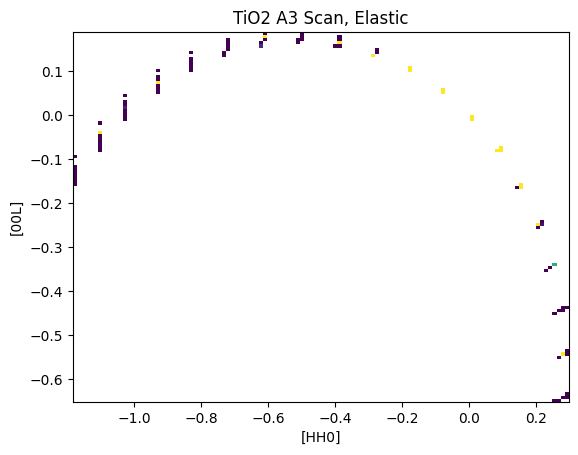

In [9]:
# The data must be converted from detector numbers and angles to the sample frame. 
macs.data.project_data_QE()
U,V,I = macs.data.bin_constE_slice(120,120,[-2,2],[-2,2],[-1,1])

plt.figure()
plt.pcolormesh(U,V,I.T,vmin=0,vmax=20)
plt.xlabel('[HH0]')
plt.ylabel('[00L]')
plt.title("TiO2 A3 Scan, Elastic")

At any point the files in the kidney scan folder can be converted into MSlice readable ng0 files. 

The files may be divided into individual Ei values or combined into a single larger one. If they originate from ng0 files, they may also be individual ng0 files corresponding to their origin files

In [24]:
#Here we combine any scans that exist individually and append them to the data holder class
macs.data.combine_all_csv()
macs.data.load_data_matrix_from_csv('_total.csv')

1

In [25]:
#The data is now written to a MACS style file for comparison in MSlice.
macs.data.write_data_to_ng0(filename='_cube_TiO2_demonstration_scan.ng0',beta_1=macs.monochromator.beta_1,\
                               beta_2=macs.monochromator.beta_2)

1